In [1]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
train_data = pd.read_csv("train.csv")

In [3]:
item_profile = pd.read_csv("item_metadata.csv")

In [8]:
#test_data = pd.read_csv("test.csv")

In [4]:
#Calculate the price of each hotel from the train_data
price = train_data[['impressions', 'prices']].copy()
price = price.dropna()

hotel_id_list = np.array(list(map(lambda x: np.array(x.split('|')),price['impressions'])))
hotel_price_list = np.array(list(map(lambda x: np.array(x.split('|')),price['prices'])))

hotel_dic = {}
for i in range(len(hotel_id_list)):
    for j in range(len(hotel_id_list[i])):
        hotel_dic[hotel_id_list[i][j]] = []
for i in range(len(hotel_id_list)):
    for j in range(len(hotel_id_list[i])):
        hotel_dic[hotel_id_list[i][j]].append(int(hotel_price_list[i][j]))
        
hotel_price_dic = dict.fromkeys(hotel_dic)
for i in hotel_dic:
    hotel_price_dic[i] = math.log(st.median(hotel_dic[i]))/10

In [5]:
hotel_dic = {}
for i in range(len(hotel_id_list)):
    for j in range(len(hotel_id_list[i])):
        hotel_dic[hotel_id_list[i][j]] = []
for i in range(len(hotel_id_list)):
    for j in range(len(hotel_id_list[i])):
        hotel_dic[hotel_id_list[i][j]].append(int(hotel_price_list[i][j]))
        
hotel_price_dic = dict.fromkeys(hotel_dic)
for i in hotel_dic:
    hotel_price_dic[i] = math.log(st.median(hotel_dic[i]))/10

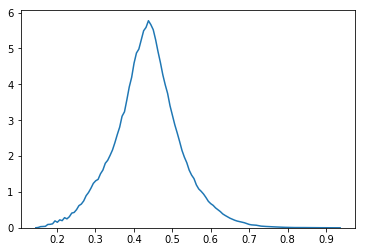

In [8]:
#dis = list(hotel_price_dic.values())
#sns.kdeplot(dis)

In [6]:
key_max = max(hotel_price_dic.keys(), key=(lambda k: hotel_price_dic[k]))
key_min = min(hotel_price_dic.keys(), key=(lambda k: hotel_price_dic[k]))
key_median = st.median(hotel_price_dic.values())
print('Maximum Value: ',hotel_price_dic[key_max])
print('Minimum Value: ',hotel_price_dic[key_min])
print('Median Value: ',key_median)

Maximum Value:  0.9210240366975849
Minimum Value:  0.16094379124341002
Median Value:  0.43567088266895915


In [7]:
#list all the properties---features for item profile
p_list = item_profile['properties'].str.split("|")
property_list = []
for i in range(len(p_list)):
    property_list += p_list[i]
property_list = list(set(property_list))
property_dict= dict.fromkeys(property_list)
for i in range(len(property_list)):
    property_dict[property_list[i]]=i

In [8]:
#create item profile
#rows are hotels in the same order as raw meta data
#columns are features in the same order as property_dictionary
#the last column is the normalized price, missing value imputed as median of the total
item_pfile = np.zeros((len(item_profile),len(property_dict)+1))
for i in range(len(p_list)):
    for j in p_list[i]:
        item_pfile[i][property_dict[j]] = 1
    if str(item_profile['item_id'][i]) in hotel_price_dic:
        item_pfile[i][len(property_dict)] = hotel_price_dic[str(item_profile['item_id'][i])]
    else:
        item_pfile[i][len(property_dict)] = key_median

In [41]:
#item dictionary key:hotel id; value hotel index
hotel_dict = {}
for i in range(len(item_profile)):
    hotel_dict[item_profile['item_id'][i]]=i

In [43]:
item_pfile

array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.47184989],
       [0.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.45643482],
       [1.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.43174881],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.3988984 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.43567088],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.43567088]])

In [42]:
hotel_dict

{5101: 0,
 5416: 1,
 5834: 2,
 5910: 3,
 6066: 4,
 6094: 5,
 6288: 6,
 6358: 7,
 6456: 8,
 6561: 9,
 6659: 10,
 6853: 11,
 7362: 12,
 7994: 13,
 8476: 14,
 8810: 15,
 9716: 16,
 ...}

In [12]:
#process the test data
from sklearn.model_selection import train_test_split
df_split = train_data.groupby('session_id')['session_id'].nunique()
df_train, df_test=train_test_split(df_split, test_size=0.2, random_state=24)

In [13]:
test=pd.DataFrame(df_test.index)
test_final=pd.merge(train_data, test, how='inner', on='session_id')

In [14]:
#to select the items that have been clicked
mask = test_final.loc[test_final['action_type'] == 'clickout item'].reset_index()

In [15]:
#remove the last row of each user session
test_userprofile = mask[['user_id', 'session_id','reference','impressions']]
test_userprofile['index'] = test_userprofile.index
test_userprofile['max'] = test_userprofile.groupby(['user_id', 'session_id']).index.transform('max')
test_userprofile['reference'] = test_userprofile['reference'].astype('int')

C:\Users\81468\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
test_userprofile.head()

,user_id,session_id,reference,impressions,index,max
0,00RL8Z82B2Z1,aff3928535f48,109038,3400638|1253714|3367857|5100540|1088584|666916...,0,1
1,00RL8Z82B2Z1,aff3928535f48,1257342,55109|129343|54824|2297972|109014|1257342|1031...,1,1
2,02SRUT1NQYH1,3599a6f709eab,2795374,2795374|5582964|1088390|2781070|1258068|127196...,2,2
3,03K8AXBL4BX2,ec139e10b9238,1032816,12693|46363|81657|18448|47687|152913|18417|927...,3,4
4,03K8AXBL4BX2,ec139e10b9238,1032816,12693|46363|81657|18448|47687|152913|18417|927...,4,4


In [76]:
true_click = test_userprofile[test_userprofile['index'] == test_userprofile['max']]
test_used = test_userprofile[test_userprofile['index'] != test_userprofile['max']]

In [78]:
test_used['weight'] = 1/(test_used['max']-test_used['index'])
test_used['sum_w'] = test_used.groupby(['user_id','session_id'])['weight'].transform('sum')
test_used['factor'] = test_used['weight']/test_used['sum_w']
test_used['user_session'] = test_used['user_id']+'_'+test_used['session_id']

C:\Users\81468\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\81468\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [86]:
test_used.head(10)

,user_id,session_id,reference,impressions,index,max,weight,sum_w,factor,user_session
26,29MC7779BSXT,574ab911584bb,4342016,4342016|150138|4345728|4454760|5708658|5874900...,26,27,1.000000,1.500000,0.666667,29MC7779BSXT_574ab911584bb


In [83]:
user_session_pfile = {}
for i in test_used.index:
    if test_used['reference'][i] in hotel_dict:
        j = hotel_dict[test_used['reference'][i]]
        user_session_pfile[test_used['user_session'][i]] = []
for i in test_used.index:
    if test_used['reference'][i] in hotel_dict:
        j = hotel_dict[test_used['reference'][i]]
        user_session_pfile[test_used['user_session'][i]].append(test_used['factor'][i]*item_pfile[j])

In [93]:
user_session_final = {}
for i in user_session_pfile:
    user_session_final[i] = sum(user_session_pfile[i])

In [96]:
true_click['user_session'] = true_click['user_id']+'_'+true_click['session_id']

C:\Users\81468\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
true_click.head()

,user_id,session_id,reference,impressions,index,max,user_session
1,00RL8Z82B2Z1,aff3928535f48,1257342,55109|129343|54824|2297972|109014|1257342|1031...,1,1,00RL8Z82B2Z1_aff3928535f48
2,02SRUT1NQYH1,3599a6f709eab,2795374,2795374|5582964|1088390|2781070|1258068|127196...,2,2,02SRUT1NQYH1_3599a6f709eab
4,03K8AXBL4BX2,ec139e10b9238,1032816,12693|46363|81657|18448|47687|152913|18417|927...,4,4,03K8AXBL4BX2_ec139e10b9238
6,06SZHKMYOOI8,4c6062d7cefe4,138930,22953|22951|22947|22949|8774118|45527|82900|22...,6,6,06SZHKMYOOI8_4c6062d7cefe4
7,098CQXLJZ868,489f31ee6fca9,129881,129881|36161|36249|464421|302607|36401|302622|...,7,7,098CQXLJZ868_489f31ee6fca9


In [105]:
user_session_fit = {}
for i in true_click.index:
    user_session_fit[true_click['user_session'][i]] = list(map(int, true_click['impressions'][i].split('|')))

In [107]:
from sklearn.metrics.pairwise import cosine_similarity

In [129]:
user_session_fit_2 = {}
for i in user_session_fit:
    if i in user_session_final:
        user_session_fit_2[i] = {}
        for j in range(len(user_session_fit[i])):
            t = user_session_fit[i][j]
            if t in hotel_dict:
                user_session_fit_2[i][user_session_fit[i][j]] = float(cosine_similarity(user_session_final[i].reshape(1,-1), item_pfile[hotel_dict[t]].reshape(1,-1)))

In [131]:
import heapq

In [133]:
import heapq
rec = dict.fromkeys(user_session_fit_2)
for i in user_session_fit_2:
    if len(user_session_fit_2) >=20:
        rec[i] = heapq.nlargest(20,user_session_fit_2[i])
    else:
        rec[i] = heapq.nlargest(len(user_session_fit_2),user_session_fit_2[i])

In [134]:
rec

{'00RL8Z82B2Z1_aff3928535f48': [10077318,
  9132132,
  8444418,
  6622154,
  3909420,
  2297972,
  2237222,
  2050977,
  1474297,
  1332971,
  1257342,
  1166793,
  1031578,
  666936,
  666916,
  129343,
  109018,
  109014,
  55109,
  55091],
 '03K8AXBL4BX2_ec139e10b9238': [4147572,
  4043482,
  1255377,
  1216900,
  1152188,
  1032816,
  927627,
  819616,
  152913,
  106567,
  106471,
  98737,
  84082,
  81657,
  47687,
  47410,
  47333,
  46363,
  18448,
  18425],
 'DPQP87FRBCJG_bb5014a7ac3eb': [3451806,
  2124046,
  1849665,
  1371672,
  1071502,
  979779,
  979757,
  921687,
  753866,
  741521,
  161527,
  161285,
  149956,
  131194,
  100504,
  40867,
  40840,
  40680,
  40638,
  40500],
 ...}

In [152]:
true_response = dict(zip(true_click['user_session'], true_click['reference']))

In [154]:
reciprocal = dict.fromkeys(rec)
for i in reciprocal:
    if true_response[i] in rec[i]:
        reciprocal[i] = 1/(rec[i].index(true_response[i])+1)
    else:
        reciprocal[i] = 0

In [155]:
import statistics

In [158]:
statistics.mean(reciprocal.values())

0.15274652122977297